In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import os

In [ ]:
#Neste problema de negócio é necessário determinar se um cliente irá cancelar seu plano ou não (churn)

In [3]:
#Carregando dataset
data = pd.read_csv('projeto4_telecom_treino.csv')
data = data.drop(columns='Unnamed: 0')
data.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [4]:
#Coletando apenas o número do area_code
data['area_code'] = data['area_code'].str.split('area_code_', n=2, expand=True)[1]

#Transformando em fatores
data.loc[:,data.dtypes == object] = data.loc[:,data.dtypes == object].apply(pd.Categorical)


data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
state,3333,51,WV,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_length,3333,NaN,NaN,NaN,101.065,39.8221,1,74,101,127,243
area_code,3333,3,415,1655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
international_plan,3333,2,no,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voice_mail_plan,3333,2,no,2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_vmail_messages,3333,NaN,NaN,NaN,8.09901,13.6884,0,0,0,20,51
total_day_minutes,3333,NaN,NaN,NaN,179.775,54.4674,0,143.7,179.4,216.4,350.8
total_day_calls,3333,NaN,NaN,NaN,100.436,20.0691,0,87,101,114,165
total_day_charge,3333,NaN,NaN,NaN,30.5623,9.25943,0,24.43,30.5,36.79,59.64
total_eve_minutes,3333,NaN,NaN,NaN,200.98,50.7138,0,166.6,201.4,235.3,363.7


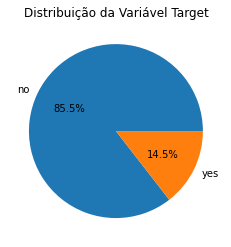

In [5]:
#Verificando a distribuição da Target
pie = data['churn'].value_counts()
plt.pie(pie,labels=pie.index,autopct="%.1f%%")
plt.title('Distribuição da Variável Target')
plt.show()

In [6]:
#Separando em Predictors e Target
X,y = data.drop(columns=['churn']),data['churn']

#ROSE - definindo a estratégia por minority
oversample = RandomOverSampler(sampling_strategy='minority')
#Aplicando o Over nos dados
X_over, y_over = oversample.fit_resample(X, y)

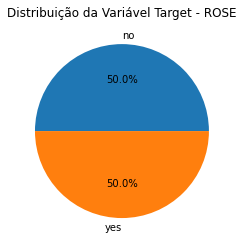

In [8]:
#Verificando Apos ROSE
(unique, counts) = np.unique(y_over,return_counts=True)
plt.pie(counts,labels=unique,autopct="%.1f%%")
plt.title('Distribuição da Variável Target - ROSE')
plt.show()

In [10]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3)

#Dividindo as colunas numéricas e categóricas
cat = X_over.loc[:,X_over.dtypes == 'category'].columns
numeric = X_over.loc[:,X_over.dtypes != 'category'].columns

#Criando preprocessamentos diferentes
numeric_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

#Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', cat_transformer, cat)])

In [11]:
#Criando lista de modelos
models = []
models.append(SGDClassifier())
models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier())
models.append(LogisticRegression(solver='liblinear'))

              precision    recall  f1-score   support

          no       0.79      0.73      0.76       848
         yes       0.75      0.81      0.78       862

    accuracy                           0.77      1710
   macro avg       0.77      0.77      0.77      1710
weighted avg       0.77      0.77      0.77      1710



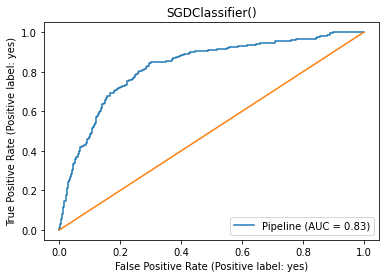

              precision    recall  f1-score   support

          no       0.95      0.82      0.88       848
         yes       0.84      0.96      0.90       862

    accuracy                           0.89      1710
   macro avg       0.90      0.89      0.89      1710
weighted avg       0.90      0.89      0.89      1710



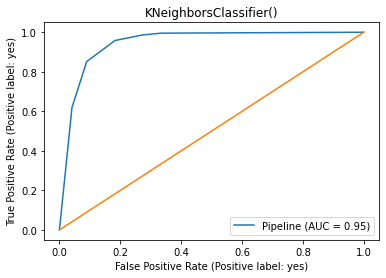

              precision    recall  f1-score   support

          no       0.99      0.92      0.96       848
         yes       0.93      0.99      0.96       862

    accuracy                           0.96      1710
   macro avg       0.96      0.96      0.96      1710
weighted avg       0.96      0.96      0.96      1710



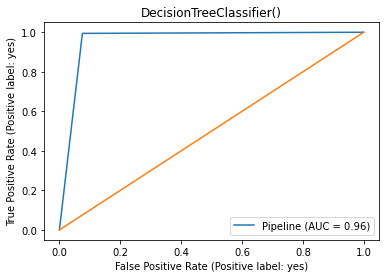

              precision    recall  f1-score   support

          no       0.79      0.79      0.79       848
         yes       0.79      0.80      0.80       862

    accuracy                           0.79      1710
   macro avg       0.79      0.79      0.79      1710
weighted avg       0.79      0.79      0.79      1710



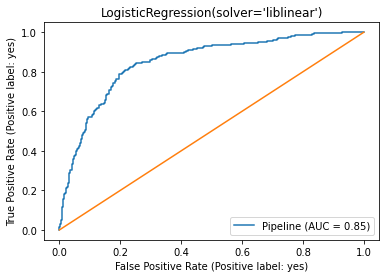

In [12]:
for model in models:
  #Creating pipeline
  clf = Pipeline(steps=[('preprocessor', preprocessor),('classifier', model)])
  clf.fit(X_train, y_train)
  #Classification report
  print(classification_report(y_test,clf.predict(X_test)))
  #Ploting ROC curve
  metrics.plot_roc_curve(clf, X_test, y_test)
  plt.plot([0, 1], [0, 1])
  plt.title(model)
  plt.show()

In [14]:
#Diversos modelos foram testados, sendo que os que apresentaram maior AUC foram o Decision Tree e o KNN.
#Foi adotado como modelo escolhido a Regressão Logística pela recomendação do projeto

In [13]:
#Imprimindo a probabilidade dos resultados
clf.predict_proba(X_test)

array([[0.71924275, 0.28075725],
       [0.62261171, 0.37738829],
       [0.05262189, 0.94737811],
       ...,
       [0.83912123, 0.16087877],
       [0.96914437, 0.03085563],
       [0.62363332, 0.37636668]])

In [ ]:
#Com isso é possível fazer ações para minimizar clientes insatisfeitos e aumentar a fidelidade